In [2]:
import torch
import torch.nn as nn
from torchgraph.tracer import TorchTracer
from torchvision import models

### Generating graph from arbitrary sequence of pytorch operations

{'__add__0': ['matmul0'], 'matmul0': ['pow0'], 'Tensor0': ['__add__0', 'matmul0'], 'Tensor1': ['__add__0'], 'pow0': ['Tensor2'], 'const0': ['pow0'], 'Tensor2': []}


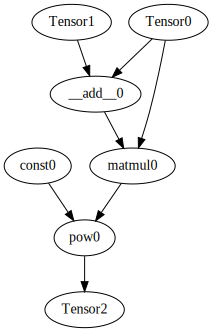

In [3]:
in1 = torch.tensor([1.])
in2 = torch.tensor([2.])

# Always run tracer with-in scope to correctly cleanup hooks inserted into torch API
with TorchTracer() as tt:
    x = in1 + in2
    y = torch.matmul(in1, x)**3

g = tt.to_graph()

# Print graph in string dictionary format
print(g.to_namegraph())

# Or visualize with graphviz
g.to_graphviz()

### Generating graph from model

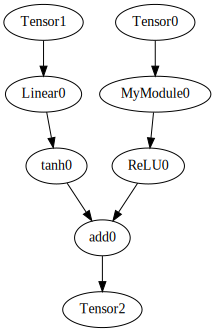

In [4]:
# Define some custom module
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.register_parameter('p', torch.nn.Parameter(torch.tensor([0.5])))

    def forward(self, x):
        return torch.mul(torch.add(torch.matmul(self.p, x), 1), 0)

# Define simple model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = MyModule()
        self.layer2 = nn.Linear(1, 1)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x1 = self.relu(self.layer1(inputs[0]))
        x2 = torch.tanh(self.layer2(inputs[1]))
        
        return torch.add(x1, x2)

model = Model()
inp = (torch.tensor([1.]), torch.tensor([1.]))

# Run tracer and trace the model, have to pass some input to invoke the model
with TorchTracer() as tt:
    tt.trace_model(model, inp)

g = tt.to_graph()
g.to_graphviz()

### Inspect modules

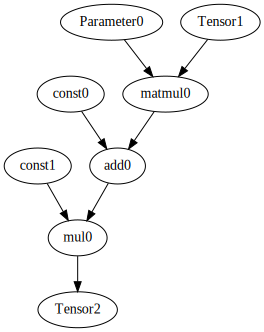

In [5]:
# Also can get operations graph of the modules
node = g.get_node('MyModule0')
ng = tt.node_to_graph(node)
ng.to_graphviz()

### Visualize ResNet18 model

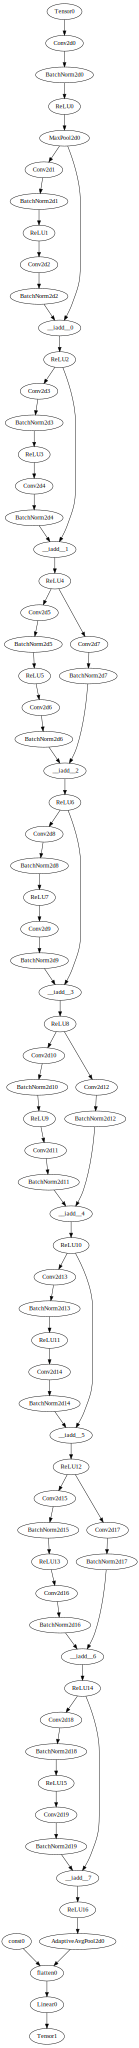

In [6]:
model = models.resnet18()

inp = torch.rand((1, 3, 224, 224))
with TorchTracer() as tt:
    tt.trace_model(model, inp)

g = tt.to_graph()
g.to_graphviz()